In [60]:
import urllib2
from bs4 import BeautifulSoup
import itertools
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import time
import nltk
from nltk.stem import WordNetLemmatizer

import pickle
from gensim import corpora, models, similarities

import psycopg2
import pandas as pd
import numpy as np
import sqlalchemy as sa
from sqlalchemy_utils import database_exists, create_database
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7  # plotsize
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 14

pd.set_option('display.max_columns', 500)

In [3]:
def Preprocessing_line(line): # perform tokenization, select noun, Lemmertization etc on a line text
    rtext=[]    
    for w, tag in nltk.pos_tag(nltk.word_tokenize(line.lower())):  # Tokenization
        if tag in ['NN']:  # Keep only Nouns (for this special case)
            rtext.append(w)
    
    wordnet_lemmatizer = WordNetLemmatizer()  # Lemmertization
    rtext = [wordnet_lemmatizer.lemmatize(w) for w in rtext]
            
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    rtext = [w for w in rtext if not w in stop_words]
    
    return rtext # return list of tokens

In [2]:
jobclass=['Data Scientist', 'Software Engineer', 'Consultant', 'Strategy Manager']
files=['Resumes_DS2.txt', 'Resumes_SE2.txt','Resumes_Con2.txt','Resumes_SM2.txt']
path = '/home/hxzheng/Insight_DS_Fellowship/Project/JobRecomm/Resume_text/'

In [5]:
job2id={}  # dictionary to map job title to jobid

for i,jc in enumerate(jobclass):
    job2id[jc]=i   

In [6]:
job2id

{'Consultant': 2,
 'Data Scientist': 0,
 'Software Engineer': 1,
 'Strategy Manager': 3}

## Load the resume texts
### Filter out resumes which are too short/long
### Preprocessing: tokenization, lemmertization, stop-words, noun-only

In [7]:
jobid=[]         # jobid from 0-3
jobtitle=[]
texts = []       # resume texts
text_length=[]
unique_count=[]


minlength=200   # mininum-length-to-keep resumes
maxlength=2000  # maximum-length-to-keep resumes
minNN=40


for i, fname in enumerate(files):
    t = time.time()
    f = open(path + fname,'r')
    for j, line in enumerate(f):
        doclen=len(line.split())
        if doclen>=minlength and doclen<=maxlength:
            text = Preprocessing_line(line)  # Preprocessing
            if len(text)>=minNN:
                if text not in texts:
                    text_length.append(len(text))
                    unique_count.append(len(set(text)))
                    jobtitle.append(jobclass[i])
                    jobid.append(job2id[jobclass[i]])
                    texts.append(text)
                    print "Done with line %d"%j     
    f.close()
    elapsed = (time.time() - t)/60  
    print "Done with file %s in %.2f minutes"%(fname,elapsed)

Done with line 0
Done with line 1
Done with line 2
Done with line 3
Done with line 4
Done with line 5
Done with line 6
Done with line 7
Done with line 8
Done with line 9
Done with line 10
Done with line 11
Done with line 12
Done with line 13
Done with line 14
Done with line 15
Done with line 17
Done with line 18
Done with line 19
Done with line 20
Done with line 21
Done with line 22
Done with line 23
Done with line 24
Done with line 25
Done with line 26
Done with line 27
Done with line 28
Done with line 29
Done with line 30
Done with line 31
Done with line 32
Done with line 33
Done with line 34
Done with line 36
Done with line 37
Done with line 38
Done with line 39
Done with line 40
Done with line 41
Done with line 42
Done with line 43
Done with line 44
Done with line 45
Done with line 46
Done with line 47
Done with line 48
Done with line 49
Done with line 50
Done with line 51
Done with line 52
Done with line 53
Done with line 54
Done with line 55
Done with line 56
Done with line 57
Do

In [8]:
### save texts
with open(path + 'texts_b4tfidf.txt', 'wb') as outfile1:
    pickle.dump(texts, outfile1, protocol =2)   

In [4]:
### read back texts
texts = pd.read_pickle(path + 'texts_b4tfidf.txt')

In [10]:
jobs = pd.DataFrame(data=None,columns=['jobid','jobtitle']) 
jobs['jobid']=jobid
jobs['jobtitle']=jobtitle
jobs['resume'] = texts
jobs['length']=text_length
jobs['unique_count']=unique_count

In [11]:
print Counter(jobtitle)
print "Total number of resumes: %d"%len(jobtitle)

Counter({'Strategy Manager': 728, 'Consultant': 707, 'Data Scientist': 691, 'Software Engineer': 690})
Total number of resumes: 2816


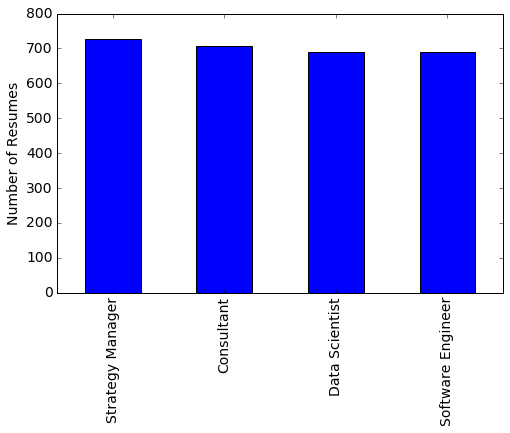

In [12]:
histgram_jobclass=jobs['jobtitle'].value_counts().plot(kind='bar')
histgram_jobclass.set_ylabel('Number of Resumes')

### create and save dictionary for id to jobtitle and jobid to keywords mapping

In [5]:
#jobs = pd.read_pickle(path + "jobs_table.dat")  
#jobs['resume'] = texts

with open(path + 'jobs_table.dat', 'wb') as outfile1:
    pickle.dump(jobs, outfile1, protocol =2)

In [13]:
id2job={}
for key, value in job2id.items():
    id2job[value] = key

with open(path+'id2job.txt', 'wb') as outfile:
    pickle.dump(id2job, outfile, protocol =2)    

### create the jobid to keywords dictionary

In [7]:
from collections import Counter

def mostfreq(words, n=60):
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return [w for w,_ in top_words]

In [17]:
jobid_keyword={}
for i in range(len(jobclass)):
    keywords=[]
    keywords = list(jobs.loc[jobs['jobid']==i]['resume'])
    keywords = itertools.chain(*keywords)
    
    keywords = mostfreq(keywords,n=100)
    jobid_keyword[i]=keywords

In [18]:
word_count = Counter(list(itertools.chain(*jobid_keyword.values())))
print word_count

Counter({'manager': 4, 'implementation': 4, 'level': 4, 'university': 4, 'team': 4, 'design': 4, 'network': 4, 'business': 4, 'web': 4, 'science': 4, 'experience': 4, 'software': 4, 'quality': 4, 'management': 4, 'service': 4, 'support': 4, 'system': 4, 'production': 4, 'company': 4, 'customer': 4, 'work': 4, 'project': 4, 'process': 4, 'engineering': 4, 'education': 4, 'technology': 4, 'information': 4, 'performance': 4, 'development': 4, 'product': 4, 'june': 4, 'm': 4, 'analysis': 4, 'client': 4, 'time': 4, 'office': 3, 'group': 3, 'knowledge': 3, 'environment': 3, 'program': 3, 'risk': 3, 'department': 3, 'report': 3, 'server': 3, 'computer': 3, 'year': 3, 'research': 3, 'access': 3, 'state': 3, 'marketing': 3, 'york': 3, 'com': 3, 'communication': 3, 'market': 3, 'strategy': 3, 'analyst': 3, 'control': 3, 'application': 3, 'test': 3, 'reporting': 3, 'sql': 3, 'center': 3, 'database': 3, 'oracle': 3, 'september': 2, 'administration': 2, 'employer': 2, 'bank': 2, 'c++': 2, 'planning

In [14]:
unique_keywords=[]
for keyword, occur in word_count.items():
    if occur<3:
        unique_keywords.append(keyword)  # keep words not appearing in all docs

for jid, keywords in jobid_keyword.items():
    newkeyword = []
    for w in keywords:
        if w in unique_keywords:
            newkeyword.append(w)
            
    jobid_keyword[jid]=newkeyword        
   
    
for j,k in jobid_keyword.items():
    print j,k    

0 ['scientist', 'r', 'machine', 'model', u'sa', u'algorithm', 'mining', 'python', 'regression', 'data', 'modeling', 'intelligence', 'processing', 'matlab', 'hadoop', 'optimization', 'decision', 'java', 'health', 'visualization', 'engineer', 'assistant', 'learning', 'consultant', 'excel', 'c++', 'd', 'use', 'tableau', 'b', 'master', 'enterprise', 'september', 'august', 'c', 'simulation', 'employer']
1 ['engineer', 'java', 'developer', 'code', 'framework', 'javascript', 'tool', 'j', 'integration', 'unit', 'c', 'html', 'end', 'spring', 'c++', 'platform', 'role', 'description', 'jquery', 'testing', 'net', 'module', 'interface', 'studio', 'user', 'maintenance', u'cs', 'architecture', 'ee', 'requirement', 'source', 'mvc', 'solution', 'jsp', 'core', 'automation', 'security', 'mysql', 'configuration', 'eclipse', 'linux', 'lead', 'functionality', 'part', 'hibernate', 'bachelor', 'script', 'cycle', 'ajax', 'document', 'language']
2 ['consultant', 'training', 'compliance', 'health', 'staff', 'sch

In [1]:
### manual selection of keywords
jobclass=['Data Scientist', 'Software Engineer', 'Consultant', 'Strategy Manager']
jobid_keyword={}
keywords_to_keep=[['r','python','machine learning','algorithm','data mining','regression','modeling',\
                  'artificial intelligence', 'data processing','hadoop','optimization','visualization','tableau','decision','java','c++','sql','enterprise','health','information','implementation','design','network','technology','customer'],
                  ['c++','java','code','developer','framework','techonology','implementation','network','javascript','automation','design','html','jquery','testing','architecture','mysql',\
                  'linux','ajax','information'],
                  ['risk','marketing','communication','training','planning','information','organization','design','network','technology','integration','insurance','inventory','customer','cash','review','leadership','compliance','health care','preparation'],
                  ['brand','revenue','growth','consumer','cost','budget','profolio','network','account',\
                  'advertising','finance','pricing','supply','acquisition','distribution','vendor','information','customer']]

for i,key in enumerate(jobclass):
    jobid_keyword[key] = keywords_to_keep[i]

In [5]:
with open(path+'jobid2keywords_freq.txt', 'wb') as outfile:
    pickle.dump(jobid_keyword, outfile, protocol =2)  

### generate the word frequency dictionary for all the resumes

In [18]:
frequency = {}
for text in texts:
    for token in text:
        frequency[token] =frequency.get(token,0)+1
        
freqsorted = [ (k,v) for v,k in sorted( [(v,k) for k,v in frequency.items()],reverse=True) ]
wordbag = []
wordfreq =[]
for wd,fq in freqsorted:
    wordfreq.append(fq)
    wordbag.append(wd)

In [32]:
print 'Total number words are: %d with %d unique words'%(sum(wordfreq),len(wordbag))
print 'Average occurence is: %.2f'%(sum(wordfreq)/float(len(wordbag)))
print 'Average number of words in each document is %.2f'%(sum(wordfreq)/len(jobid))
n=50
print "The top %d words are:"%n 
print freqsorted[:n] 

Total number words are: 709998 with 28116 unique words
Average occurence is: 25.25
Average number of words in each document is 252.00
The top 50 words are:
[('business', 10755), ('management', 9885), ('development', 9120), ('software', 7927), ('project', 7548), ('team', 7075), ('analysis', 6853), ('experience', 6561), ('system', 5856), ('university', 5424), ('product', 5332), ('manager', 5203), ('marketing', 5072), ('design', 4757), ('customer', 4698), ('application', 4515), ('information', 4373), ('work', 4234), ('strategy', 4138), ('client', 4135), ('research', 3925), ('process', 3548), ('engineer', 3361), ('support', 3333), ('company', 3283), ('service', 3206), ('sql', 3189), ('test', 3117), ('technology', 2930), ('web', 2900), ('performance', 2876), ('time', 2719), ('market', 2715), ('education', 2646), ('program', 2596), ('server', 2592), ('science', 2539), ('database', 2530), ('engineering', 2349), ('consultant', 2312), ('implementation', 2256), ('quality', 2213), ('environment',

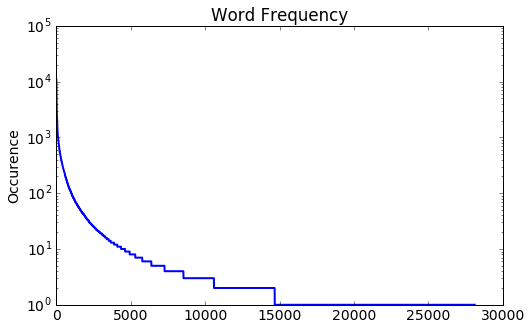

In [23]:
index=np.linspace(1,len(wordfreq)+1,len(wordfreq))

plt.plot(index,wordfreq)
plt.title("Word Frequency")
plt.ylabel("Occurence")
plt.yscale('log')

### save the jobs table

In [24]:
jobs['resume'] = texts  # keep only the first 50 words

with open(path + 'jobs_table.dat', 'wb') as outfile1:
    pickle.dump(jobs, outfile1, protocol =2)
    
# read back the table     

#jobs=pd.read_pickle("jobs_table1.dat")    

In [5]:
jobs=pd.read_pickle(path + "jobs_table.dat")    
jobs.head()

,jobid,jobtitle,resume,length,unique_count
0,0,Data Scientist,"[vikas, patil, scientist, company, boulder, co...",212,142
1,0,Data Scientist,"[robert, sousek, scientist, consultant, canton...",222,138
2,0,Data Scientist,"[kris, ford, engineer, hampton, ga, engineerin...",372,200
3,0,Data Scientist,"[joydeep, singh, architect, scientist, directv...",546,278
4,0,Data Scientist,"[ahmad, scientist, chief, officer, ahmad, scie...",193,113


In [7]:
texts = jobs['resume']

## Exploratory Data Analysis

In [25]:
class MyCorpus(object):
    def __iter__(self):
        for text in texts:
            yield dictionary.doc2bow(text)
            
dictionary = corpora.Dictionary(texts)
dictionary.compactify() # remove gaps in id sequence after words that were removed
dictionary.save(path + 'indeed.dict') # store the dictionary, for future reference

my_corpus = MyCorpus()
corpora.MmCorpus.serialize(path+'IndeedCorpus.mm', my_corpus) # store to disk, for later use

### tfidf histogram

In [26]:
tfidf = models.TfidfModel(my_corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[my_corpus]

In [27]:
tfidfscore = [score for _,score in list(itertools.chain(*corpus_tfidf))]

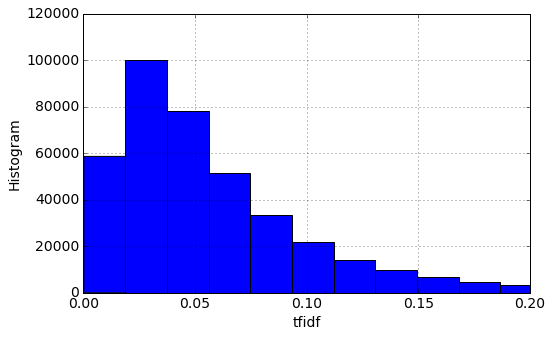

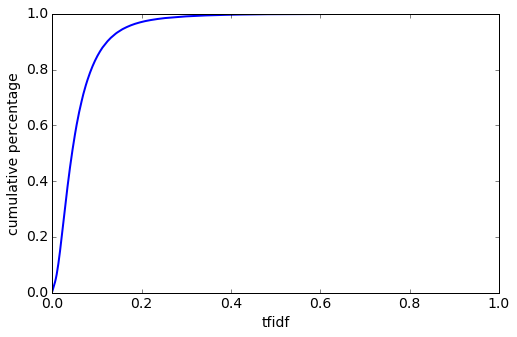

In [28]:
pd.Series(tfidfscore).hist(bins=50)
plt.xlabel("tfidf")
plt.ylabel("Histogram")
plt.xlim(0,0.2)
plt.show()

values, base = np.histogram(np.array(tfidfscore), bins=500)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative/float(cumulative[-1]), c='blue')
plt.xlabel('tfidf')
plt.ylabel('cumulative percentage')
plt.xlim(0,1.0)
plt.show()

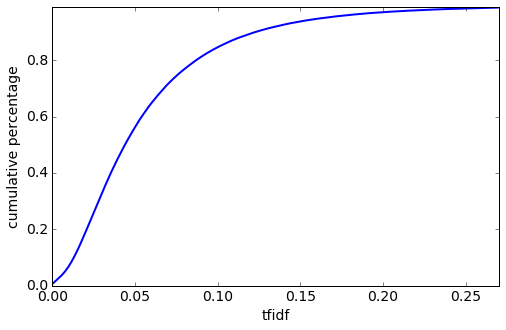

In [38]:
plt.plot(base[:-1], cumulative/float(cumulative[-1]), c='blue')
plt.xlabel('tfidf')
plt.ylabel('cumulative percentage')
plt.xlim(0,0.25)
plt.ylim(0,0.99)
plt.show()

<b>Threshold of tf-idf<br>
0.024: 25%, 0.043: 50%, 0.076: 75%, 0.12: 90%

### Resume length and unique word count histograms (nouns only)

In [30]:
jobs.shape

(2816, 5)

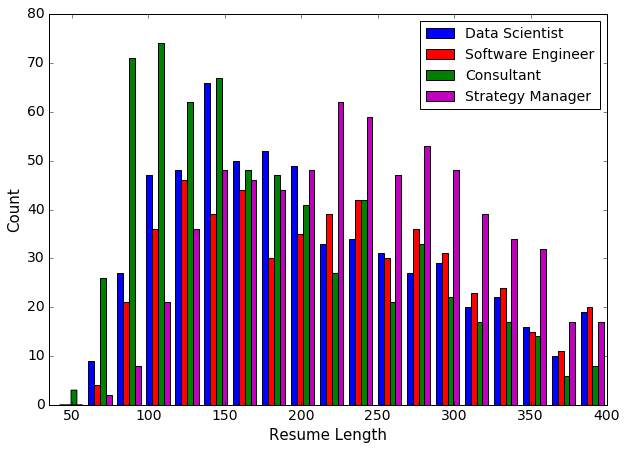

In [62]:
bins = np.linspace(40, 400, 20)
colors=['b','r','g','m']
labels=[]
resume_length=[]
for i in xrange(len(jobclass)):
    resume_length.append( ( (jobs.loc[jobs['jobid']==i]['length']).values ).tolist() )
    labels.append(jobclass[i])
      
#resume_length=(np.array(resume_length)).T
#print resume_length

plt.figure()
plt.hist(resume_length,bins=bins, alpha=1.0,label=labels,color=colors)
plt.xlabel("Resume Length",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xlim(35,400)
plt.ylim(0,80)
plt.legend(loc='upper right',fontsize=14)
plt.savefig(path + 'Resume_Length_Histogram.png', bbox_inches='tight')